In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import numpy.random as npr

%matplotlib inline

We're going to see how to use Bayesian Poisson estimation to model proportion data.

Let's say there are three bacteria species that characterize the gut, and we hypothesize that they are ever so shifted off from one another, but we don't know how (i.e. ignore the data-generating distribution below). Can we figure out the proportion parameters and their uncertainty?

Here, every patient is one sample, and we are recording the number of sequencing reads corresponding to some OTUs (bacteria). Each row is one sample (patient), and each column is one OTU (sample).

In [90]:
def proportion(arr):
    return arr / arr.sum()

healthy_proportions = np.array([10, 16, 2]) / np.sum([10, 16, 2])
healthy_proportions

array([ 0.35714286,  0.57142857,  0.07142857])

In [91]:
sick_proportions = np.array([10, 27, 15]) / np.sum([10, 27, 15])
sick_proportions

array([ 0.19230769,  0.51923077,  0.28846154])

In [92]:
n_data_points = 100

def make_healthy_multinomial(arr):
    n_sequencing_reads = npr.poisson(lam=50)
    return npr.multinomial(n_sequencing_reads, healthy_proportions)

def make_sick_multinomial(arr):
    n_sequencing_reads = npr.poisson(lam=50)
    return npr.multinomial(n_sequencing_reads, sick_proportions)

# Generate healthy data
healthy_reads = np.zeros((n_data_points, 3))
healthy_reads = np.apply_along_axis(make_healthy_multinomial, axis=1, arr=healthy_reads)

# Generate sick reads
sick_reads = np.zeros((n_data_points, 3))
sick_reads = np.apply_along_axis(make_sick_multinomial, axis=1, arr=sick_reads)

In [93]:
# Make pandas dataframe
healthy_df = pd.DataFrame(healthy_reads)
healthy_df.columns = ['bacteria1', 'bacteria2', 'bacteria3']

sick_df = pd.DataFrame(sick_reads)
sick_df.columns = ['bacteria1', 'bacteria2', 'bacteria3']

healthy_df.mean()

bacteria1    17.55
bacteria2    28.63
bacteria3     3.57
dtype: float64

In [94]:
sick_df.mean()

bacteria1     8.97
bacteria2    26.32
bacteria3    15.10
dtype: float64

The modelling strategy here uses the raw data. We start by modelling the counts of the healthy and the sick peoples' bacteria (e.g. number of counts in sequencing reads), and deterministicaly computing the proportions (and their associated uncertainty).

$$ \mu_{healthy} \sim DiscreteUniform(0, 100) $$

$$ counts_{healthy} \sim Poisson(\mu_{healthy}) $$

$$ p_{healthy} = \frac{counts_{healthy, i}}{sum(counts_{healthy})} $$

In [95]:
with pm.Model() as poisson_model:
    healthy_mu = pm.DiscreteUniform('healthy_mu', 0, 100, shape=(3,))
    healthy_counts = pm.Poisson('healthy_counts', mu=healthy_mu, shape=(3,), observed=healthy_df)
    healthy_proportions = pm.Deterministic('healthy_proportions', healthy_mu / healthy_mu.sum())
    
    sick_mu = pm.DiscreteUniform('sick_mu', 0, 100, shape=(3,))
    sick_counts = pm.Poisson('sick_counts', mu=sick_mu, shape=(3,), observed=sick_df)
    sick_proportions = pm.Deterministic('sick_proportions', sick_mu / sick_mu.sum())
    
    diff_proportions = pm.Deterministic('diff_proportions', healthy_proportions - sick_proportions)

In [97]:
with poisson_model:
    poisson_trace = pm.sample(draws=10000)

Assigned Metropolis to healthy_mu
Assigned Metropolis to sick_mu
100%|██████████| 10000/10000 [00:01<00:00, 6739.61it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f08dac371d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f08e02df780>]], dtype=object)

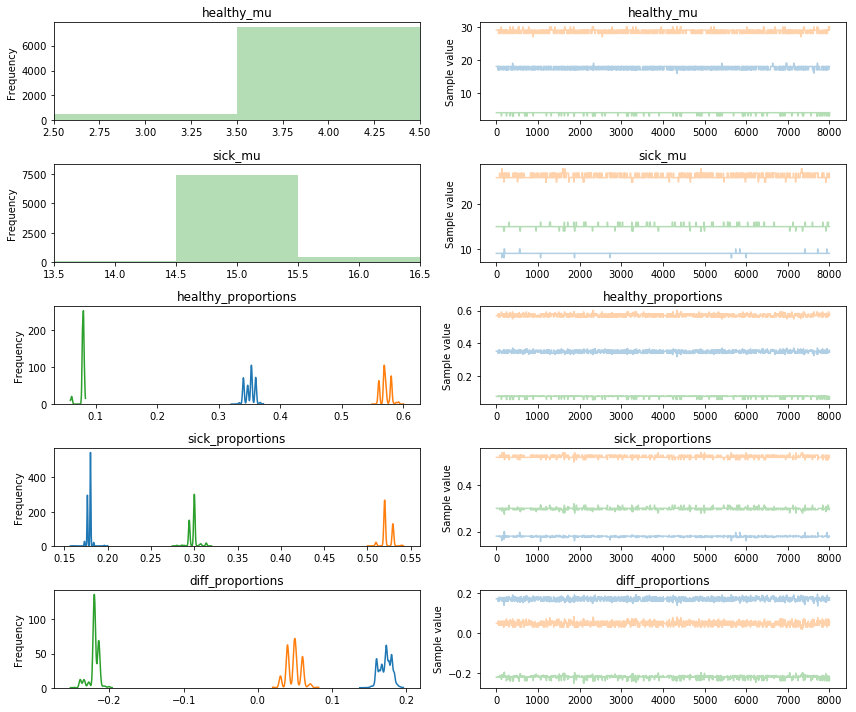

In [98]:
pm.traceplot(poisson_trace[2000:])

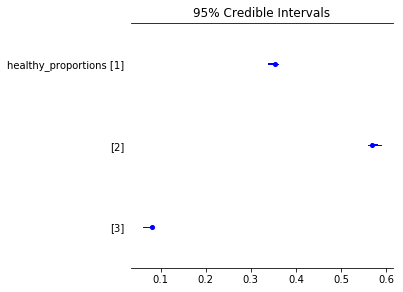

In [99]:
pm.forestplot(poisson_trace, varnames=['healthy_proportions'])

What happens if we don't have the raw counts data, but only the proportions? Can we use Bayesian estimation to help us find the population proportions for healthy, and its associated uncertainty?

Firstly, we assume that the each of the `p`s come from a Uniform(0, 1). We won't restrict them to be summed to 1; the likelihood function will be the Student's T distribution.

In [100]:
df = pd.concat([healthy_df, sick_df])
df_norm = df.apply(lambda x: proportion(x), axis=1)
df.head(5)

,bacteria1,bacteria2,bacteria3
0,20,32,2
1,16,26,5
2,19,25,4
3,20,33,3
4,16,31,2


In [103]:
with pm.Model() as tdist_model:
    p1 = pm.Uniform('p1', 0, 1)
    p2 = pm.Uniform('p2', 0, 1)
    p3 = pm.Deterministic('p3', 1 - p1 - p2)
    # ps = pm.Uniform('ps', shape=(3,))
    std = pm.Exponential('std', lam=0.5, shape=(3,))
    nu = pm.Poisson('nu', mu=1, shape=(3,))
    
    like = pm.StudentT('like', mu=[p1, p2, p3], sd=std, nu=nu, observed=df_norm[0:n_data_points])

In [104]:
with model:
    tdist_trace = pm.sample(draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -817.9: 100%|██████████| 200000/200000 [01:16<00:00, 2621.00it/s]    
Finished [100%]: Average ELBO = -817.91
100%|██████████| 2000/2000 [00:13<00:00, 147.33it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f08e0c90128>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f08e0afe908>]], dtype=object)

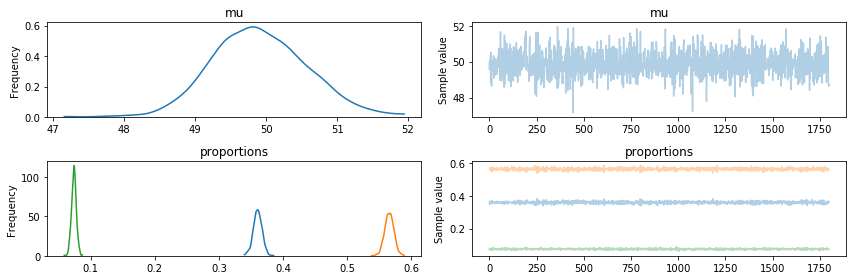

In [111]:
pm.traceplot(tdist_trace[200:])

In [113]:
tdist_trace['proportions'].mean(axis=0)

array([ 0.36053489,  0.5654913 ,  0.07397381])

In [114]:
healthy_df.mean() / healthy_df.mean().sum()

bacteria1    0.352764
bacteria2    0.575477
bacteria3    0.071759
dtype: float64

Here's a final formulation, using the Dirichlet/Multinomial distribution.

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -821.03: 100%|██████████| 200000/200000 [01:18<00:00, 2552.05it/s]   
Finished [100%]: Average ELBO = -821.02
100%|██████████| 2000/2000 [00:13<00:00, 143.38it/s]


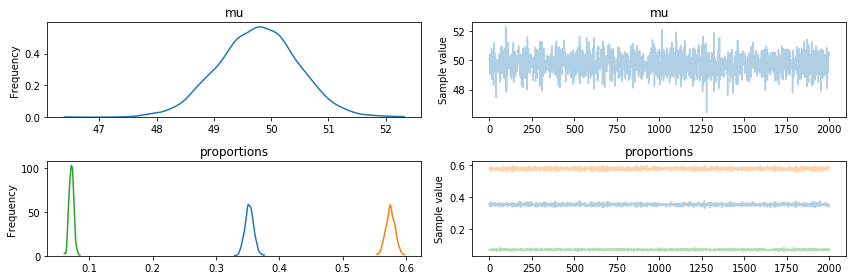

In [115]:
with pm.Model() as dirichlet_model:
    mu = pm.HalfNormal('mu', sd=100**2)
    n_seq_reads = pm.Poisson('n_seq_reads', mu=mu, observed=healthy_reads.sum(axis=1))
    proportions = pm.Dirichlet('proportions', a=np.ones(3), shape=(3,))
    for i in range(healthy_reads.shape[0]):
        draws = pm.Multinomial(f'draws_{i}', n=healthy_reads[i].sum(), p=proportions, observed=healthy_reads[i,:])
    dirichlet_trace = pm.sample(draws=2000)
    pm.traceplot(dirichlet_trace)

In [116]:
pm.summary(dirichlet_trace)


mu:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  49.768           0.695            0.016            [48.325, 51.026]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  48.384         49.321         49.772         50.223         51.128


proportions:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.353            0.007            0.000            [0.338, 0.365]
  0.575            0.007            0.000            [0.560, 0.588]
  0.072            0.004            0.000            [0.065, 0.079]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.339          0.348          0